In [1]:
'''
Initializes python packages and give paths to appropriate files to be used like categories file,
the twitter file to be used alongwith the default stopword list (This is where our own created stoplist will be declared too).
'''
from __future__ import print_function
from IPython.display import display
import datetime, calendar, nltk, string, math, csv, glob, ntpath, os.path
import numpy as np
from gensim.models import Phrases
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer; wnl = WordNetLemmatizer()
import warnings, matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#from rirdc_lib_old import cleanUp, calculate_seed
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()
from sklearn.cluster import KMeans
import matplotlib.image as mpimg
from matplotlib import cm
import pandas as pd

path = r'C:\Users\n9553291\Documents'
stopwords_file, categories_file = path+'\\stopwords.txt', path+'\\Category_DomainTerms.txt' # {(category, term)}
out_fname,out_fname_cluster = path+'\\new_data_file.csv',path+'\\cluster_data_file.csv'
extra_cats_file=path+'\\extra_cats.txt'

#Give the wordnet path here
wordnet_path=path+'\\corpora\\wn-domains-3.2\\wn-domains-3.2-20070223'

n_topics, seed_ratio = 5, 0.25
max_df, min_df = 0.5, 0.1 # For the VSM
topic_groups=[]

def keywithmaxval(d):
    v=list(d.values());k=list(d.keys())
    return k[v.index(max(v))]

value=int(input("1 for twitter and 2 for patents"))
if value==1:
    data_file=path+'\\results-20170725-145833.csv'
elif value==2:
    data_file=path+'\\urlpatentout2017_1.csv'
print('Loading packages and file paths declarations done...')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:819: DeprecationWarning: invalid escape sequence \w
  if re.match('\w:', url) or re.match(r'\\', url):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:947: DeprecationWarning: invalid escape sequence \s
  if re.search('^\s', token) or re.search('\s$', token):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:947: DeprecationWarning: invalid escape sequence \s
  if re.search('^\s', token) or re.search('\s$', token):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:3650: DeprecationWarning: invalid escape sequence \|
  elif re.match('(or|\|\|)', conditional):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:3880: DeprecationWarning: invalid escape s

1 for twitter and 2 for patents1
Loading packages and file paths declarations done...


In [2]:
#Creates a new file from the tweet file by getting rid of rows that are incomplete by appending their content to the 
#preceding row and deleting blank rows
test_file=open(data_file,encoding="ISO-8859-1")
twitter_file = open(out_fname_cluster, 'w',encoding="ISO-8859-1",newline='')
reader = csv.reader(test_file, delimiter=',')
writer = csv.writer(twitter_file)
next(reader,None)
prev=reader
for row in reader:
    if row[0] in (None, ""):
        continue
    for term in row[3]:
        if term.isalpha()==False or ord(term) > 127:
            row[3]=row[3].replace(term,' ')
        wnl.lemmatize(term,'n')
    writer.writerow(row)
test_file.close()
twitter_file.close()
print('Done Creating the cleaned version of tweet file...')

Done Creating the cleaned version of tweet file...


In [3]:
# Loading the Wordnet domains.
s2d = []
for i in open(wordnet_path, 'r'):
    ssid, doms = i.strip().split('\t')
    doms = doms.split()
    for d in doms:
        s2d.append(d)
synset2domains=list(set(s2d))
extra_cats={}

for syn in synset2domains:
    try:
        p_list,c_list,categories=[],[],[]
        obj=wn.synset(syn+'.n.01')
        topics=obj.topic_domains()
        parents=obj.hypernyms()
        children=obj.hyponyms()
        domains= [ topic.lemma_names() for topic in topics ] 
        for sublist in domains:
            for item in sublist:
                    categories.append(str(item.replace('_',' ')))
        pwords = [ parent.lemma_names() for parent in parents ]
        for sublist in pwords:
            for item in sublist:
                    p_list.append(str(item.replace('_',' ')))
        cwords = [ child.lemma_names() for child in children]
        for sublist in cwords:
            for item in sublist:
                    c_list.append(str(item.replace('_',' ')))
        words=p_list+c_list
        if categories:
            for category in categories:
                extra_cats[category]=words
    except:
        pass

out_extra_cats = open(extra_cats_file, 'w')
for k in extra_cats.keys():
    for v in extra_cats[k]:
        out_extra_cats.write(k+", ")
        out_extra_cats.write(v+"\n")
out_extra_cats.close()
print("Done creating extra categories..")

Done creating extra categories..


In [4]:
#Creates the equal number of files for the unique months and locations present 
#in the data file and dumps corresponding tweets to the appropriate ones.

input_file = open(out_fname_cluster,encoding="ISO-8859-1")
date_list,country_list=[],[]
reader = csv.reader(input_file, delimiter=',')

#Creates a unique list of months and countries from tweets
for row in reader:
    created_at,*rest=row[1].split(' ')           #splits the 'Created at' column to retrieve 'month'
    year,months,date=created_at.split('-')
    month=calendar.month_name[int(months)]
    if month not in date_list:
        date_list.append(str(month))
'''
    if row[6] not in country_list:
        country_list.append(str(row[6]))
'''
#Creates csv files with names after months
for month in date_list:
    outfile = open(path+'\Data{0:2s}'.format(str(month))+'.csv', 'w', newline='',encoding="ISO-8859-1")
    writer = csv.writer(outfile, delimiter = ',')
    writer.writerow(["tweet_id","month","text","country"])
    outfile.close()
'''
#Creates csv files with names after countries
for country in country_list:
   outfile = open(path+'\Data{0:2s}'.format(str(country))+'.csv', 'w', newline='',encoding="ISO-8859-1")
   writer = csv.writer(outfile, delimiter = ',')
   writer.writerow(["tweet_id","month","text","country"])
   outfile.close()
'''
#Shifts rows of tweets to their respective csv files  -->  For Months
for month1 in date_list:
  with open(out_fname_cluster, 'r',encoding="ISO-8859-1") as f:
    reader = csv.reader(f, delimiter=',')
    outfile = open(path+'\Data{0:2s}'.format(str(month1))+'.csv','a', newline='',encoding="ISO-8859-1")
    for row in reader:
        if row[0] in (None, ""):
          continue
        created_at,*rest=row[1].split(' ')  
        year,months,date=created_at.split('-')
        month2=calendar.month_name[int(months)]
        if month1==month2:
            writer = csv.writer(outfile, delimiter =',')
            writer.writerow(row)
    outfile.close()
'''
#Shifts rows of tweets to their respective csv files  -->  For Countries
for country1 in country_list:
  with open(out_fname, 'r',encoding="ISO-8859-1") as f:
    reader = csv.reader(f, delimiter=',')
    outfile = open(path+'\Data{0:2s}'.format(str(country1))+'.csv','a', newline='',encoding="ISO-8859-1")
    for row in reader:
        if row[0] in (None, ""):
          continue
        country2=str(row[6])
        if country1==country2:
            writer = csv.writer(outfile, delimiter =',')
            writer.writerow(row)
    outfile.close()
'''
print('Done moving tweets to their respective months and location files...')

<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:32: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence \D
<input>:32: DeprecationWarning: invalid escape sequence \D
<input>:21: DeprecationWarning: invalid escape sequence 

Done moving tweets to their respective months and location files...


In [5]:
#Tokenizes and remove stopwords from the tweet column of the data file for bigrams and unigrams --> For Months

df=open(stopwords_file,"r",encoding="ISO-8859-1", errors='replace')
stops=df.readlines(); df.close()
stops = set([word.strip() for word in stops])                  #stores stopwords tokens from the stoplist in a list
stops1=list(stops)
stops2=''.join(stops1)
tweet_id_m, text_m={},{}
tweet_id_c,text_c={},{}
docs,r=[],[]
sentences=[]
DocZ_m, DocZ_c, DocZ_m_wob, DocZ_c_wob = {},{},{},{} # will be used to find categories
for month in date_list:
    u,p,d,d_wob=[],[],[],[]
    outfile = open(path+'\Data{0:2s}'.format(str(month))+'.csv', 'r', newline='',encoding="ISO-8859-1")
    reader = csv.reader(outfile, delimiter=',')
    next(reader,None)
    docs=list(reader);
    for doc in docs:    
        tmp = [t.strip() for t in doc]
        try:
            if len(tmp[3])>0: # Making sure not blanks
                sentence = [word
                    for word in nltk.word_tokenize(tmp[3].lower())
                    if word not in string.punctuation
                           and len(word)>3
                           ]
                filtered_word_list = sentence[:] #make a copy of the word_list
                for term in sentence: # iterate over word_list
                    if term in stops2: 
                        filtered_word_list.remove(term)
                d_wob.append(tmp[3].lower())                  #Unigrams List
                sentences.append(filtered_word_list)                  #Bigrams List
                filtered=' '.join(filtered_word_list)
                u.append(tmp[0]); p.append(tmp[3]);d.append(filtered)
        except:
            pass
    tweet_id_m[month]=u
    text_m[month]=p 
    DocZ_m[month]=d
    DocZ_m_wob[month]=d_wob
   
print("For the months found")
print("The bigrams are -->", DocZ_m)
#print("The unigrams are -->", DocZ_m_wob)

#Gets the top five bigrams
flat_list = [item for sublist in sentences for item in sublist]
word_counter = {}
for word in flat_list:
     if word in word_counter:
        word_counter[word] += 1
     else:
         word_counter[word] = 1
popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_5 = popular_words[:5]
print("The top five bigrams are",top_5)
del u,p,d,d_wob,sentence
    
del docs
print("Clean-up for months done...,", end = ' ', flush = True)  

<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence \D
<input>:15: DeprecationWarning: invalid escape sequence 

For the months found
The bigrams are --> {'July': ['amyschumer planning publicity australian tour', 'angry misogynist murders women showing film feminist comedian police worry bsxogg davidfutrelle', 'simpsonsqotd lisa super nintendo chalmers', 'somearebent industry able give weeks clear caulfield guineas emirates stakes', 'love kqiry', 'waynecarey terms pressure teams talented hawks cover mitchell standing game unqu', 'tell loved book finished immediately started gidlnhfbx', 'samfazz talking carter reynolds just fall deep irrelevancy inevitably', 'boots atthehairdresser leopardprint boots fashion mirror reflection qnhrz', 'brooksbeau sunset vibes dirty stuff soon qfigpzsvgv', 'thefunnyteens texts back weeks sorry fell asleep', 'brooksbeau sunset vibes dirty stuff soon qfigpzsvgv', 'jaclynhill best advice give year girl looking start future love fellow florida girl', 'hawthorn star mitchell shrugs wayne carey jibe mitchell joked work ycjm', 'longer episodessss ucjeva', 'signature fusion

In [6]:
#transforming the corpus into vector space using tf-idf

tfidf_vectorizer,tfidf_matrix,terms={},{},{}
for m in date_list:
    tfidf_vectorizer[m] = TfidfVectorizer(max_df=0.5, max_features=200000,
                                 min_df=10,stop_words='english', ngram_range=(1,3))
    tfidf_matrix[m] = tfidf_vectorizer[m].fit_transform(DocZ_m[m]) #fit the vectorizer to tweets
    terms[m] = tfidf_vectorizer[m].get_feature_names()
print(terms)
print("VSM done...")

{'July': ['abbott', 'able', 'absolutely', 'abuse', 'action', 'adelaide', 'agreed', 'agreed forward', 'agreed forward motion', 'album', 'alpconf', 'alpconf auspol', 'amazing', 'announced', 'apositivemessage', 'asylum', 'august', 'auspol', 'aussie', 'australia', 'australian', 'available', 'away', 'awesome', 'baby', 'backs', 'backs damage', 'backs damage international', 'ball', 'barbaracordavias', 'barbaracordavias gmail', 'barbaracordavias gmail calibraskaep', 'beautiful', 'believe', 'benpobjie', 'best', 'better', 'billshortenmp', 'birthday', 'bishop', 'black', 'blog', 'boat', 'boats', 'book', 'boys', 'breakfast', 'bring', 'brisbane', 'bronwyn', 'bronwyn bishop', 'brooksbeau', 'brother', 'build', 'business', 'calibraskaep', 'calibraskaep jackgilinsky', 'calibraskaep jackgilinsky jackjackjohnson', 'camerondallas', 'canterbury', 'canterbury tips', 'canterbury tips ybxgwpn', 'care', 'carter', 'chance', 'change', 'check', 'child', 'children', 'china', 'choppergate', 'city', 'clear', 'club', 

In [7]:
#clustering the documents using the k-means algorithm

clusters={}
num_clusters = 5        #specify the number of clusters here
km = KMeans(n_clusters=num_clusters,random_state=4000)
for m in date_list:
    km.fit(tfidf_matrix[m])
    clusters[m] = km.labels_.tolist()
print("Clustering done..")

Clustering done..


In [8]:
#creates a dictionary for cluster-docs pair

tweets,frame,mydict={},{},{}
for m in date_list:
    tweets[m] = { 'tweets': DocZ_m[m], 'cluster': clusters[m] }
    frame[m] = pd.DataFrame(tweets[m], index=None,columns = ['tweets', 'cluster'])
    #frame['cluster'].value_counts()
    mydict[m]={k: list(v) for k,v in frame[m].groupby("cluster")["tweets"]}
print(mydict)

{'July': {0: ['biggy jarrapin independentaus hope helps turn left auspol ksbgvgqtfi', 'girt people boat turn backs land stay', 'vulnerable aussies afford properly turn heaters coldest winter decade jujzrf', 'getup seen australian today calling australianlabor vote boat turn backs alpconf', 'getup seen australian today calling australianlabor vote boat turn backs alpconf', 'crowd turn autism expo darebin arts centre', 'turn backs move concentrate gonski medicare super rorts know economy think', 'billshortenmp latham turn backs', 'spilsbury orama boat turn backs transfield unhcr care refugees', 'carterreynolds concerned turn please australia', 'boeufblogginon shorten intro sight shore facilities staff prison secret turn back water blah', 'richsimmondsza life takes unexpected wrong turn right direction unknown quote roxanamjones', 'turn firstworldcatproblems nzlgbmzxd', 'greens turn backs want vote libs stay power refugees treatment labor change', 'amnestyoz shorten backflip boat turn bac

In [9]:
# Loading categories into category dictionary of set of terms for bigrams and unigrams 

print("Please wait (it's going to take a while): Loading Data,", end = ' ', flush = True)
df=open(categories_file,"r",encoding="ISO-8859-1", errors='replace')
cats=df.readlines(); df.close(); categories = {}
for cat in cats:
     key = cat.split(', ')[0].strip(); term = cat.split(', ')[1].strip().lower()
     try:        
          categories[key].add(term)
     except:
          categories[key] = set([term])               #stores categories-terms as a key-value in a dictionary from the file
del cats,df

df=open(extra_cats_file,"r",encoding="ISO-8859-1", errors='replace')
cats=df.readlines(); df.close(); 
for cat in cats:
     key = cat.split(', ')[0].strip(); term = cat.split(', ')[1].strip().lower()
     try:        
          categories[key].add(term)
     except:
          categories[key] = set([term])               #stores categories-terms as a key-value in a dictionary from the file
del cats,df
print("pre-Categories mapping ... ", flush = True)    
doc_cats_m,doc_cat_m = {}, {}; 
doc_cats_m_wob,doc_cat_m_wob={},{};
for month in date_list:
  doc_cats_m[month],doc_cat_m[month]={},{} 
  for cluster_id in range(0,num_clusters):
     doc_cats_m[month][cluster_id],doc_cat_m[month][cluster_id]={},{}
     for idx,doc in enumerate(mydict[month][cluster_id]):
        notInCategories,total=[],0
        doc_cats_m[month][cluster_id][idx]={}
        for cat, terms in categories.items():
            for term in terms:
                n = doc.count(term)              #calculates the frequency of occurance of terms corresponding to terms for the category
                total+=n
                try:
                    doc_cats_m[month][cluster_id][idx][cat] += n
                except:
                    doc_cats_m[month][cluster_id][idx][cat]= n
        for cat, terms in categories.items():
            if total==0:
                doc_cat_m[month][cluster_id][idx] = None
                doc_cats_m[month][cluster_id][idx][cat] = 0.0
                if month not in notInCategories:
                    notInCategories.append(month)
            else:
                doc_cat_m[month][cluster_id][idx] = keywithmaxval(doc_cats_m[month][cluster_id][idx])           # category of doc[idx]
                doc_cats_m[month][cluster_id][idx][cat] = doc_cats_m[month][cluster_id][idx][cat]/total          # Normalizing to category's ratio
                
del doc
print(doc_cat_m)
print('%d/%d Documents were not in any of the categories.' %(len(notInCategories), len(mydict)), flush = True)

Please wait (it's going to take a while): Loading Data, pre-Categories mapping ... 
{'July': {0: {0: None, 1: None, 2: 'mining', 3: 'finance', 4: 'finance', 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: 'commercial enterprise', 12: 'mining', 13: None, 14: None, 15: None, 16: 'mining', 17: None, 18: 'mining', 19: None}, 1: {0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: 'mining', 8: None, 9: None, 10: 'computer', 11: 'computer', 12: 'computer', 13: None, 14: 'computer', 15: None, 16: None, 17: None, 18: None, 19: None, 20: None, 21: 'computer', 22: None, 23: None, 24: 'mining', 25: None, 26: None, 27: None, 28: None, 29: None, 30: 'computer', 31: 'computer', 32: 'mining', 33: 'mining', 34: None, 35: None, 36: None, 37: 'mining', 38: None, 39: None, 40: None, 41: None, 42: None, 43: None, 44: 'computer', 45: None, 46: None, 47: None, 48: None, 49: None, 50: None, 51: None, 52: None, 53: 'computer', 54: 'commercial enterprise', 55: None, 56: 'mining', 57: N

In [10]:
#Calculates a score for each domain for each document
topic_categories_freq, topic_categories_score = {}, {}
for month in date_list:
 topic_categories_freq[month],topic_categories_score[month]={},{}
 for cluster_id in range(0,num_clusters):
#topics_groups = [[1,12],[2,18],[3,7,9,14,15,19],[4],[5],[6,8,11],[10,13,16,17],[20]] # Change this depending on the visualization result; PS: this is "LDAtopic+1"
#topics_scores, seeds, seeds_score, clusters, centroids, mse = {}, {}, {}, {}, {}, {}
      topic_categories_freq[month][cluster_id], topic_categories_score[month][cluster_id] = {}, {}
      temp=[]  
      for k,v in doc_cat_m[month][cluster_id].items():
        C=doc_cat_m[month][cluster_id][k]
        temp.append(doc_cat_m[month][cluster_id][k])
        if C: #not None
            try:
                topic_categories_freq[month][cluster_id][C]+=1
                topic_categories_score[month][cluster_id][C]+=doc_cats_m[month][cluster_id][k][C]
            except:
                topic_categories_freq[month][cluster_id][C]=1
                topic_categories_score[month][cluster_id][C]=doc_cats_m[month][cluster_id][k][C]
        else:
            try:
                topic_categories_freq[month][cluster_id]['None']+=1
            except:
                topic_categories_freq[month][cluster_id]['None']=1  
      for k,v in categories.items():
        if k not in temp:
            topic_categories_freq[month][cluster_id][k]=0.0
            topic_categories_score[month][cluster_id][k]=0.0
    # Normalizing scores
      for C in topic_categories_freq[month][cluster_id].keys():
        if C is not 'None':
            N = topic_categories_freq[month][cluster_id][C]
            if N !=0:
                topic_categories_score[month][cluster_id][C] = topic_categories_score[month][cluster_id][C]/N
            else:
                topic_categories_score[month][cluster_id][C] = 0.0
      if topic_categories_freq[month][cluster_id]['agriculture'] == topic_categories_freq[month][cluster_id]['finance'] == topic_categories_freq[month][cluster_id]['mining'] == 0.0:
        topic_categories_freq[month][cluster_id]['None']=1 
      if topic_categories_score[month][cluster_id]['agriculture'] == topic_categories_score[month][cluster_id]['finance'] == topic_categories_score[month][cluster_id]['mining'] == 0.0:
        topic_categories_score[month][cluster_id]['None']=1 
print(topic_categories_freq)
print(topic_categories_score)
print ('Done assigning scores...')
    # doc_cats[idx][cat] ; 
    #seeds[str(topic)], seeds_score[str(topic)] = calculate_seed(dtm_tf,doc_topic,tf_terms,topic,categories,seed_ratio) # return Dictionary [categories]:{docs} ==> nested dict
    #clusters[str(topic)], centroids[str(topic)], mse[str(topic)] = ss_clustering(vsm_topics,seeds[str(topic)],doc_topic,topic) # k from len(seeds[str(topic)])

{'July': {0: {'None': 13, 'mining': 4, 'finance': 2, 'commercial enterprise': 1, 'agriculture': 0.0, 'meteorology': 0.0, 'dramaturgy': 0.0, 'dramatic art': 0.0, 'dramatics': 0.0, 'theater': 0.0, 'theatre': 0.0, 'mathematics': 0.0, 'math': 0.0, 'maths': 0.0, 'architecture': 0.0, 'drama': 0.0, 'computer': 0.0, 'computing machine': 0.0, 'computing device': 0.0, 'data processor': 0.0, 'electronic computer': 0.0, 'information processing system': 0.0, 'art': 0.0, 'artistic creation': 0.0, 'artistic production': 0.0, 'science': 0.0, 'scientific discipline': 0.0, 'industry': 0.0, 'manufacture': 0.0, 'business enterprise': 0.0, 'business': 0.0, 'military': 0.0, 'armed forces': 0.0, 'armed services': 0.0, 'military machine': 0.0, 'war machine': 0.0, 'linguistics': 0.0}, 1: {'None': 82, 'mining': 16, 'computer': 13, 'commercial enterprise': 1, 'finance': 1, 'agriculture': 0.0, 'meteorology': 0.0, 'dramaturgy': 0.0, 'dramatic art': 0.0, 'dramatics': 0.0, 'theater': 0.0, 'theatre': 0.0, 'mathematic

In [11]:

words_dict,words,termss={},{},{}
for month in date_list:
    tfidf_vectorizer[month] = TfidfVectorizer(max_df=1.0, max_features=200000,
                                 min_df=9,stop_words='english', ngram_range=(1,3))
    termss[month] = {}
    words_dict[month],words[month]={},{}
    for cluster_id in range(0,num_clusters):
        tfidf_matrix[month] = tfidf_vectorizer[month].fit_transform(mydict[month][cluster_id])
        km.fit(tfidf_matrix[month])
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        vocab_frame = pd.DataFrame({'words': mydict[month][cluster_id]}, index = mydict[month][cluster_id])
        words_dict[month][cluster_id]={}
        words[month][cluster_id]={}
        termss[month][cluster_id]=tfidf_vectorizer[month].get_feature_names()
        #sort cluster centers by proximity to centroid
        for ind in order_centroids[cluster_id, :6]: #replace 6 with n words per cluster
            words[month][cluster_id]=str(vocab_frame.ix[termss[month][cluster_id][ind].split(' ')].values.tolist()[0][0]).encode('ascii', 'ignore').decode()
        if cluster_id not in words_dict[month]:
            words_dict[month][cluster_id]=[]
        #print(words)
    for idx in range(0,num_clusters):
        word=words[month][idx]
        if word in words_dict[month][idx] or word=='nan':
                continue
        else:
                words_dict[month][idx]=word
print(words_dict)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing o

{'July': {0: {}, 1: {}, 2: {}, 3: 'want', 4: 'love'}, 'August': {0: 'baby', 1: {}, 2: 'photo', 3: {}, 4: {}}, 'September': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}, 'October': {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


For month July
For Cluster ID 0
Visualization based on Category frequency: 


<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: DeprecationWarning: invalid escape sequence \P
<input>:3: Dep

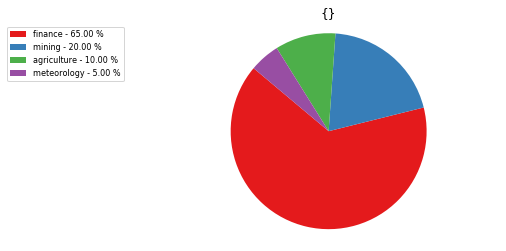

For Cluster ID 1
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


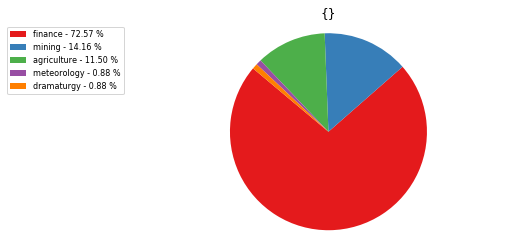

For Cluster ID 2
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


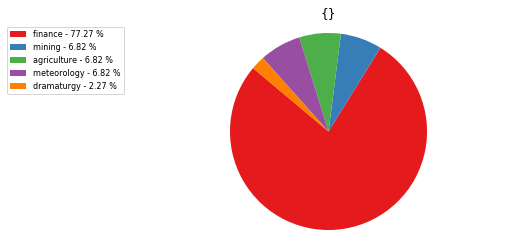

For Cluster ID 3
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


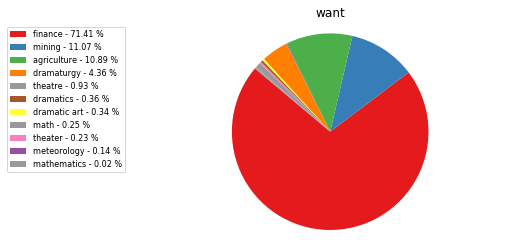

For Cluster ID 4
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


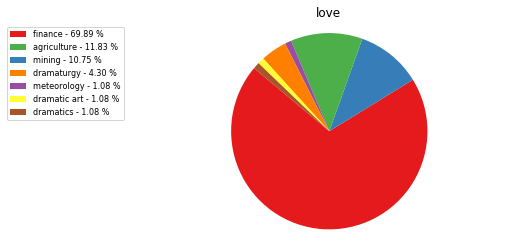

For month August
For Cluster ID 0
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


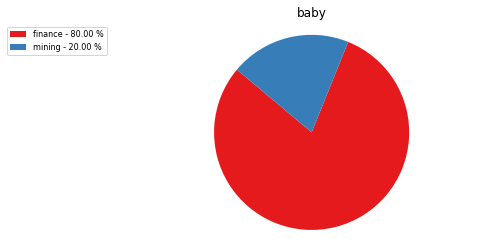

For Cluster ID 1
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


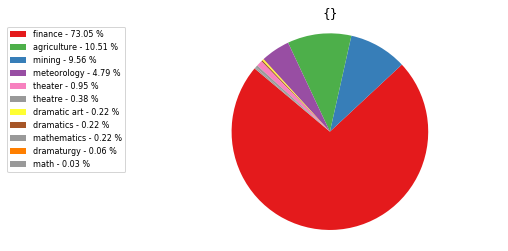

For Cluster ID 2
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


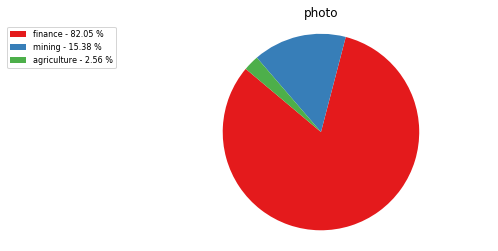

For Cluster ID 3
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


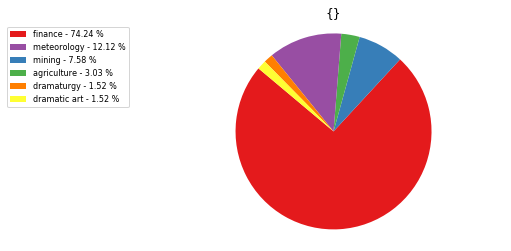

For Cluster ID 4
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


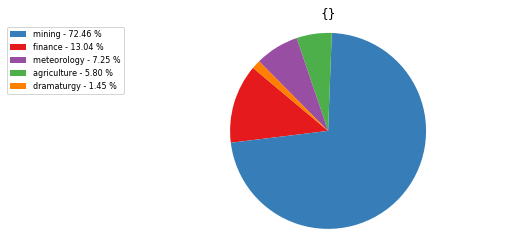

For month September
For Cluster ID 0
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


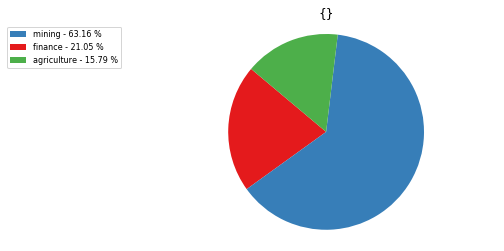

For Cluster ID 1
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


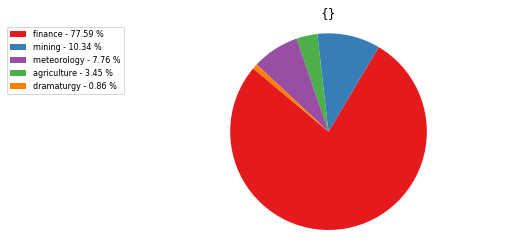

For Cluster ID 2
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


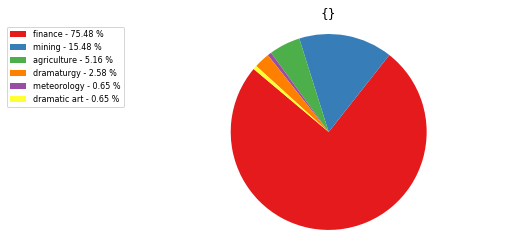

For Cluster ID 3
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


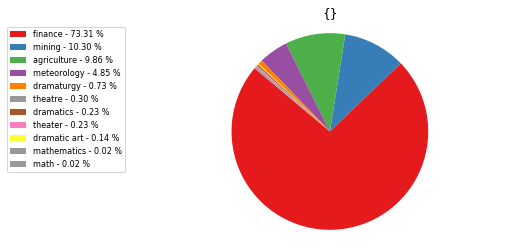

For Cluster ID 4
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


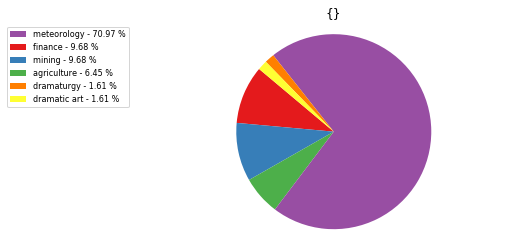

For month October
For Cluster ID 0
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


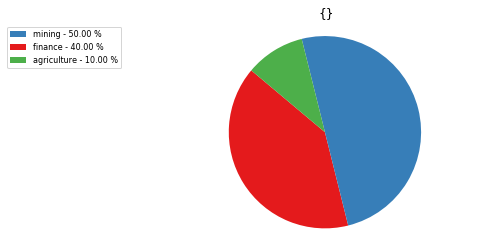

For Cluster ID 1
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


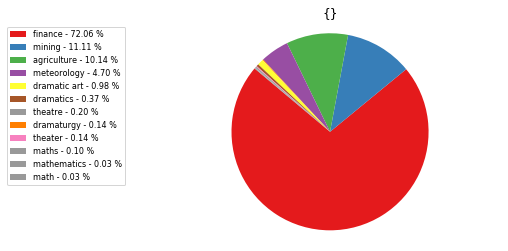

For Cluster ID 2
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


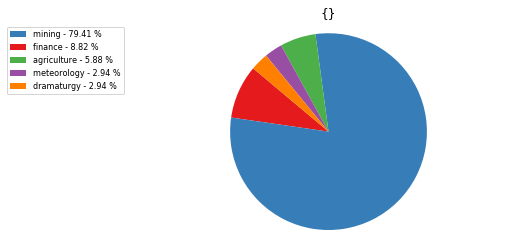

For Cluster ID 3
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


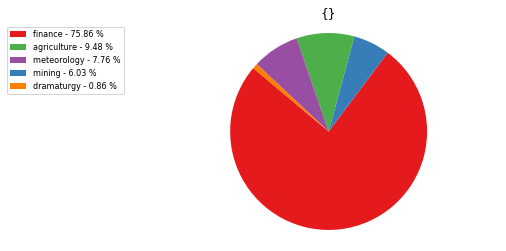

For Cluster ID 4
Visualization based on Category frequency: 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  app.launch_new_instance()


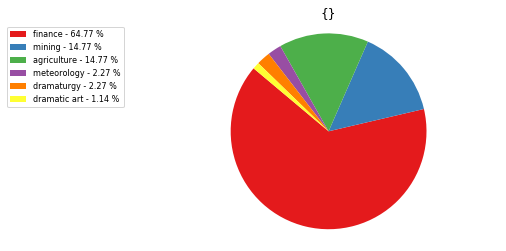

Done Visualising and saving pie charts...


In [14]:
#Creates a pie chart and saves it as a png file to be loaded later

fileNameTemplate = path+'\Plot{0:s}'
categoryy_list=categories.keys()
categoryy_list=list(categoryy_list)
for month in date_list:
    print("For month",month)
    for cluster_id in range(0,num_clusters):
        print("For Cluster ID",str(cluster_id))
        print('Visualization based on Category frequency: ', flush = True)
        y=np.array(list(topic_categories_freq[month][cluster_id].values()))
        percent = 100.*y/y.sum()
        indices=np.where(percent == 0)[0].tolist()
        porcent=np.delete(percent,indices)
        np.asarray(categoryy_list)
        category_list=np.delete(categoryy_list,indices).tolist()
        labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(category_list, porcent)]
        sizes = list(topic_categories_freq[month][cluster_id].values())
        cs=cm.Set1(np.arange(len(labels)))
        #colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','lightskyblue'][:len(labels)]
        explode = (0.1, 0, 0, 0)  # explode 1st slice: Change this anyway you like
        patches,text=plt.pie(sizes, colors=cs, startangle=140)
        plt.title(words_dict[month][cluster_id])
        plt.axis('equal')
        sort_legend = True
        if sort_legend:
            patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                              key=lambda x: x[2],
                                              reverse=True))

        plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
               fontsize=8)
        plt.savefig(fileNameTemplate.format(str(month)+'-'+str(cluster_id)+'.png'), format='png', bbox_inches='tight')
        plt.show()
print('Done Visualising and saving pie charts...')

In [ ]:
#Loads back the saved png pie charts to be displayed over cluster axis

fig, axarr = plt.subplots(nrows=len(date_list),ncols= num_clusters, sharex='col', sharey='row',  figsize=(40,5))
c=0   
r=0
if len(date_list)==1:
    axarr[0].yaxis.set_label_position("left")
    axarr[0].set_ylabel(date_list[0])
    c=0
    for col in range(0,num_clusters):
        ttl=''
        for top in col:
            ttl=ttl+mydict[str(top)]+','
        axarr[c].set_title(ttl)
        img=fileNameTemplate.format(str(col))+'-'+date_list[0]+'.png'
        o=axarr[c].imshow(mpimg.imread(img),interpolation='nearest', aspect='auto')
        plt.setp(axarr[c].get_xticklabels(), visible=False)
        plt.setp(axarr[c].get_yticklabels(), visible=False)
        c+=1
    
#else use numpy multi-dimesnional array
else:
     r=0
     for row in date_list:
        c=0
        axarr[r,0].yaxis.set_label_position("left")
        axarr[r,0].set_ylabel(row)
        for col in range(0,num_clusters):  
            ttl=''
            ttl=ttl+str(words_dict[row][col])+','
            axarr[r,c].set_title(ttl)
            img=fileNameTemplate.format(str(row)+'-'+str(col))+'.png'
            o=axarr[r,c].imshow(mpimg.imread(img),interpolation='nearest',aspect='auto')
            plt.setp(axarr[r,c].get_xticklabels(), visible=False)
            plt.setp(axarr[r,c].get_yticklabels(), visible=False)
            c+=1
        r+=1
plt.show()
print("Done plotting for months...")
print("Done plotting ...")